<a id="top"></a>
# Clustering Notebook
<hr>

# Notebook Summary

This notebook demonstrates how to use Open Data Cube utilities to cluster geospatial data. 

<hr>

# Outline

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Maximum Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents) (selecting too much can make the acquisition process slow)
* [Load Data from the Data Cube and Create a Composite](#retrieve_data)
* [Examine the Composite and Export as a GeoTIFF](#examine_composite)
* [Perform Clustering](#cluster)
* [Visualize the Clustered Data](#visualize)
* [Export the Clustered Data as a GeoTIFF](#export_clustered_data)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datacube
import datetime as dt
import xarray as xr  
import numpy as np

from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.plotter_utils import figure_ratio

In [2]:
api = DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

**Examine available products**

In [3]:
# Get available products
products_info = dc.list_products()

In [4]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


**Choose product and platform**

In [10]:
product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

## <span id="extents">Get the Maximum Extents of the Cube [&#9652;](#top)</span>

In [11]:
from utils.data_cube_utilities.dc_load import get_product_extents

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

print("{}:".format(platform))
print("Lat bounds:", full_lat)
print("Lon bounds:", full_lon)
print("Time bounds:", min_max_dates) 

LANDSAT_8:
Lat bounds: (-12.63361111121218, 18.40166666681388)
Lon bounds: (-25.47250000020378, 44.01000000035208)
Time bounds: (datetime.datetime(2013, 3, 21, 8, 18, 2, 182000), datetime.datetime(2020, 1, 27, 10, 9, 38, 78000))


In [12]:
from utils.data_cube_utilities.dc_display_map import display_map

# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

**Specify start and end dates in the same order as platforms and products**

In [13]:
# from datetime import datetime 
# start_date, end_date = (datetime(2010,1,1), datetime(2011,1,1))
# start_date, end_date = dt.datetime(2014,1,1), dt.datetime(2016,1,1)
start_date, end_date = dt.datetime(2014,9,1), dt.datetime(2015,3,1)
date_range = (start_date, end_date)

**Specify an area to analyze**

In [21]:
# Specify latitude and longitude bounds of an interesting area within the full extents

# Vietnam
# lat_small = (9.8, 9.85) # Area #1
# lon_small = (105.1, 105.15) # Area #1

# Ghana
# Weija Reservoir - North
lat_small = (5.5974, 5.6270)
lon_small = (-0.3900, -0.3371)

**Visualize the selected area**

In [22]:
display_map(latitude = lat_small,longitude = lon_small)

## <span id="retrieve_data">Load Data from the Data Cube and Create a Composite [&#9652;](#top)</span>

**Create geographic chunks for efficient processing**

In [23]:
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks

geographic_chunks = create_geographic_chunks(
                                latitude=lat_small, 
                                longitude=lon_small, 
                                geographic_chunk_size=.05)

**Create a geomedian composite**

In [24]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic

measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.load(measurements = measurements,
                   time = date_range,
                   platform = platform,
                   product =  product,
                   longitude=chunk['longitude'],
                   latitude=chunk['latitude'])
    # Mask out clouds and scan lines.
    clean_mask = landsat_qa_clean_mask(data, platform)
    # Create the mosaic.
    product_chunks.append(create_hdmedians_multiple_band_mosaic(data, clean_mask=clean_mask, dtype=np.float32))

**Combine the chunks to produce the final mosaic**

In [25]:
from utils.data_cube_utilities.dc_chunker import combine_geographic_chunks
final_composite = combine_geographic_chunks(product_chunks)

## <span id="examine_composite">Examine the Composite and Export as a GeoTIFF [&#9652;](#top)</span>

> ### True color 

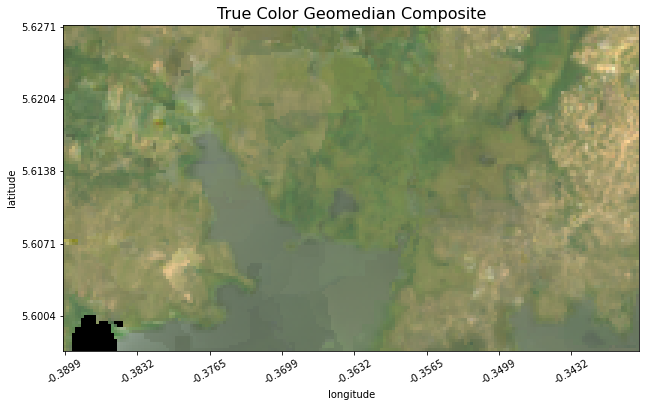

In [26]:
from utils.data_cube_utilities.dc_rgb import rgb

fig = plt.figure(figsize=figure_ratio(final_composite, fixed_width=8, fixed_height=8))
rgb(final_composite, bands=['red', 'green', 'blue'], fig=fig,
    use_data_min=True, use_data_max=True)
plt.title('True Color Geomedian Composite', fontsize=16)
plt.show()

> ### False color 

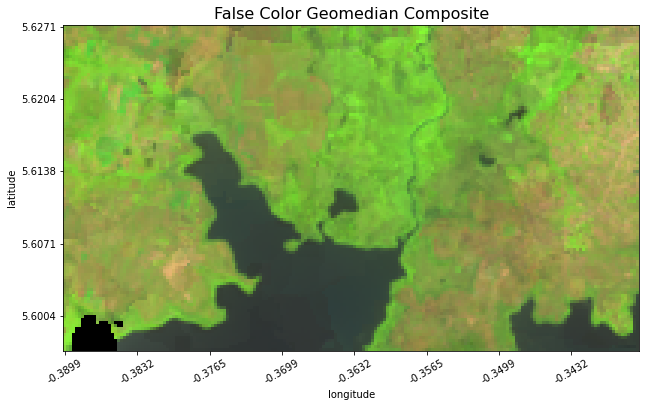

In [27]:
fig = plt.figure(figsize=figure_ratio(final_composite, fixed_width=8, fixed_height=8))
rgb(final_composite, bands=['swir1', 'nir', 'red'], fig=fig, 
    use_data_min=True, use_data_max=True)
plt.title('False Color Geomedian Composite', fontsize=16)
plt.show()

> ### Example of a composited `swir1` band

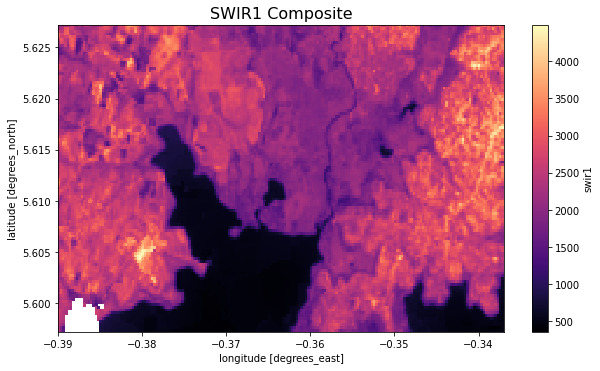

In [28]:
final_composite.swir1.plot(figsize = figure_ratio(final_composite, fixed_width=10, 
                                               fixed_height=10), cmap = 'magma')
plt.title('SWIR1 Composite', fontsize=16)
plt.show()

> ### Export to GeoTIFF

In [29]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff
import os
geotiff_dir = 'output/geotiffs/Clustering_Notebook'
if not os.path.exists(geotiff_dir):
    os.makedirs(geotiff_dir)
export_slice_to_geotiff(final_composite, '{}/final_composite.tif'.format(geotiff_dir))

## <span id="cluster">Perform Clustering [&#9652;](#top)</span>

In [30]:
from utils.data_cube_utilities.dc_load import xr_scale_res

In [31]:
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset, get_frequency_counts

# Bands used for clustering
cluster_bands = ['red', 'green', 'blue', 'swir1']

classification_4 =  kmeans_cluster_dataset(final_composite, cluster_bands, n_clusters=4)
freq_counts_4 =     get_frequency_counts(classification_4)
classification_8 =  kmeans_cluster_dataset(final_composite, cluster_bands, n_clusters=8)
freq_counts_8 =     get_frequency_counts(classification_8)
classification_12 = kmeans_cluster_dataset(final_composite, cluster_bands, n_clusters=12)
freq_counts_12 =    get_frequency_counts(classification_12)

## <span id="visualize">Visualize the Clustered Data [&#9652;](#top)</span> 

In [32]:
# Define standard formatting.
def get_figsize_geospatial(fixed_width=8, fixed_height=14, 
                           num_cols=1, num_rows=1):
    return figure_ratio(final_composite, 
                        fixed_width=fixed_width, fixed_height=fixed_height,
                        num_cols=num_cols, num_rows=num_rows)
xarray_imshow_params = dict(use_colorbar=False, use_legend=True, 
                            fig_kwargs=dict(dpi=120, figsize=get_figsize_geospatial()))

There were 144 data points that had missing data, comprising 0.70% of all data points.
There were 3423 data points in class 0, comprising 16.59% of all data points.
There were 7189 data points in class 1, comprising 34.85% of all data points.
There were 7345 data points in class 2, comprising 35.61% of all data points.
There were 2527 data points in class 3, comprising 12.25% of all data points.


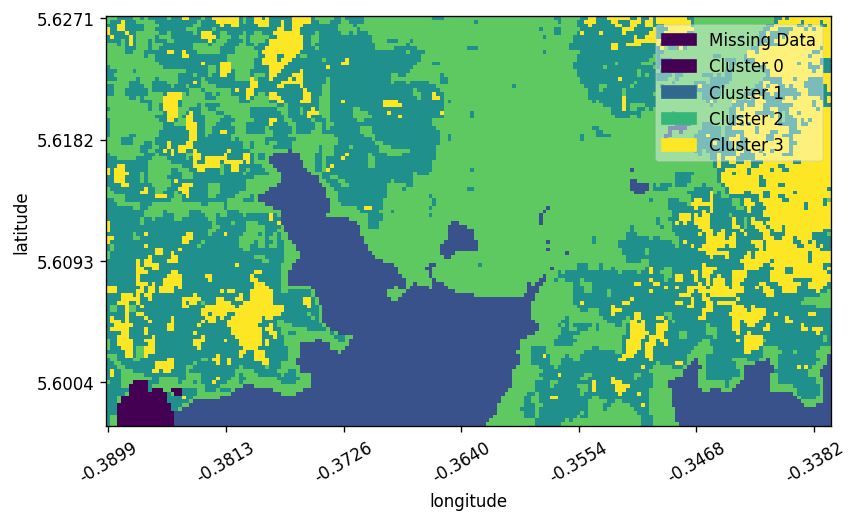

In [33]:
from utils.data_cube_utilities.plotter_utils import xarray_imshow

for class_num, freq, fractional_freq in freq_counts_4:
    # The `*_cluster_dataset()` functions set -1 as the cluster number for "rows" with missing data.
    class_num, freq = int(class_num), int(freq)
    class_mem_str = "in class {:d}".format(class_num) if class_num != -1 else "that had missing data"
    print("There were {:d} data points {}, comprising {:.2%} "\
          "of all data points.".format(int(freq), class_mem_str, 
                                       fractional_freq))
legend_labels = {v:"Cluster {}".format(v) if v != -1 else "Missing Data" for v in np.unique(classification_4)}
xarray_imshow(classification_4, **xarray_imshow_params, legend_labels=legend_labels)
plt.show()

There were 144 data points that had missing data, comprising 0.70% of all data points.
There were 3311 data points in class 0, comprising 16.05% of all data points.
There were 3320 data points in class 1, comprising 16.09% of all data points.
There were 1631 data points in class 2, comprising 7.91% of all data points.
There were 1457 data points in class 3, comprising 7.06% of all data points.
There were 3618 data points in class 4, comprising 17.54% of all data points.
There were 491 data points in class 5, comprising 2.38% of all data points.
There were 3553 data points in class 6, comprising 17.22% of all data points.
There were 3103 data points in class 7, comprising 15.04% of all data points.


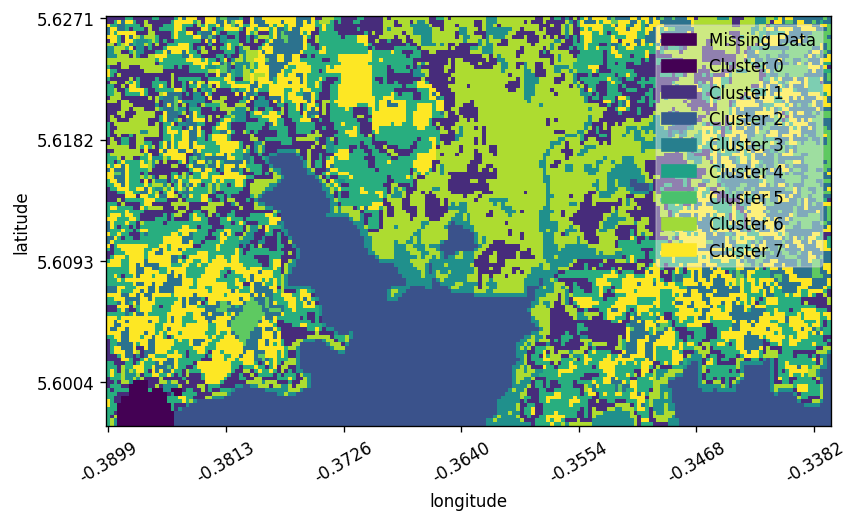

In [34]:
for class_num, freq, fractional_freq in freq_counts_8:
    # The `*_cluster_dataset()` functions set -1 as the cluster number for "rows" with missing data.
    class_num, freq = int(class_num), int(freq)
    class_mem_str = "in class {:d}".format(class_num) if class_num != -1 else "that had missing data"
    print("There were {:d} data points {}, comprising {:.2%} "\
          "of all data points.".format(int(freq), class_mem_str, 
                                       fractional_freq))
legend_labels = {v:"Cluster {}".format(v) if v != -1 else "Missing Data" for v in np.unique(classification_8)}
xarray_imshow(classification_8, **xarray_imshow_params, legend_labels=legend_labels)
plt.show()

There were 144 data points that had missing data, comprising 0.70% of all data points.
There were 2768 data points in class 0, comprising 13.42% of all data points.
There were 2324 data points in class 1, comprising 11.27% of all data points.
There were 1831 data points in class 2, comprising 8.88% of all data points.
There were 305 data points in class 3, comprising 1.48% of all data points.
There were 990 data points in class 4, comprising 4.80% of all data points.
There were 1278 data points in class 5, comprising 6.20% of all data points.
There were 2812 data points in class 6, comprising 13.63% of all data points.
There were 952 data points in class 7, comprising 4.62% of all data points.
There were 2295 data points in class 8, comprising 11.13% of all data points.
There were 614 data points in class 9, comprising 2.98% of all data points.
There were 2475 data points in class 10, comprising 12.00% of all data points.
There were 1840 data points in class 11, comprising 8.92% of all

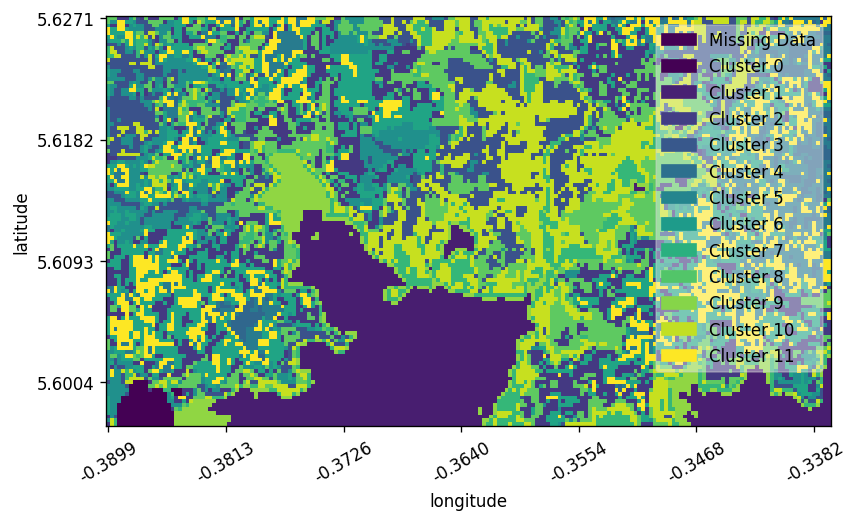

In [35]:
for class_num, freq, fractional_freq in freq_counts_12:
    # The `*_cluster_dataset()` functions set -1 as the cluster number for "rows" with missing data.
    class_num, freq = int(class_num), int(freq)
    class_mem_str = "in class {:d}".format(class_num) if class_num != -1 else "that had missing data"
    print("There were {:d} data points {}, comprising {:.2%} "\
          "of all data points.".format(int(freq), class_mem_str, 
                                       fractional_freq))
legend_labels = {v:"Cluster {}".format(v) if v != -1 else "Missing Data" for v in np.unique(classification_12)}
xarray_imshow(classification_12, **xarray_imshow_params, legend_labels=legend_labels)
plt.show()

## <span id="export_clustered_data">Export the Clustered Data as a GeoTIFF [&#9652;](#top)</span>

In [36]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

if not os.path.exists(geotiff_dir):
    os.makedirs(geotiff_dir)

output_kmeans_cluster4_file_path  =  os.path.join(geotiff_dir, "cluster4_kmeans.tif")
output_kmeans_cluster8_file_path  =  os.path.join(geotiff_dir, "cluster8_kmeans.tif")
output_kmeans_cluster12_file_path =  os.path.join(geotiff_dir, "cluster12_kmeans.tif")

export_slice_to_geotiff(classification_4.to_dataset(name='classification'), 
                        output_kmeans_cluster4_file_path)
export_slice_to_geotiff(classification_8.to_dataset(name='classification'), 
                        output_kmeans_cluster8_file_path)
export_slice_to_geotiff(classification_12.to_dataset(name='classification'), 
                        output_kmeans_cluster12_file_path)